# DH Algorithm

Developed by Sanjoy **D**asgupta and Daniel **H**su, the DH algorithm operates on a hierarchical clustering. Iteratively, it works its way through the hierarchical tree and (in loose terms) estimates the error if the subsequent tree (pruning) were assigned the majority label to all the nodes. 

This implementation of DH is adapted from Haotian Teng's implementation, found at https://github.com/haotianteng/DH.

In [1]:
from dh import HierarchicalSampling as HS
import copy
import warnings
import numpy as np 
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from numpy.random import choice
from scipy.cluster.hierarchy import linkage
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import ClusterNode
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")

In [2]:
#helper function: make v folds for cross-validation
def create_folds(data, v = 5):
    #initialize the folds
    folds = []
    
    #get the number of examples
    n = len(data)
    #get the size of each fold
    fold_size = n // v

    #shuffle the data
    data = data.sample(frac = 1).reset_index(drop = True)

    #iterate through the folds
    for i in range(v):
        #get the start and end indices for the fold
        start = i * fold_size
        end = (i + 1) * fold_size

        #get the fold
        fold = data.iloc[start:end]
        folds.append(fold)

    return folds

#helper function: given labelled data, learn a classifier
def LearnClassifier(data): 
    #create folds for cross-validation
    folds = create_folds(data)
    accs = []

    for i in range(len(folds)):
        #get the training and validation sets
        val = folds[i]
        #training is all other folds combined
        train = pd.concat(folds[:i] + folds[i+1:])

        #check: the validation set must have >1 example
        if len(val) <= 1:
            return None, np.nan

        #initialize the classifier
        clf = RandomForestClassifier(n_estimators = 20, max_depth = 7, random_state = 42)
        clf.fit(train.iloc[:, :-1], train.iloc[:, -1])

        #calculate the accuracy
        acc = clf.score(val.iloc[:, :-1], val.iloc[:, -1])
        accs.append(acc)

    acc = np.mean(accs)

    return clf, acc

#helper function: take in a dataframe, cluster it with k-means where k-is the number of classes
#then evaluate each class's jaccard index with the true labels
def evaluate_clustering(data):
    labels = data.iloc[:, -1]
    data = data.iloc[:, :-1]

    #get the number of classes
    n_classes = len(np.unique(labels))

    #initialize the k-means classifier
    kmeans = KMeans(n_clusters = n_classes, random_state = 42)

    #fit the k-means classifier
    kmeans.fit(data)

    #get the predicted labels
    pred_labels = kmeans.labels_

    #initialize the jaccard index
    jaccard_indexes = []

    #iterate through the classes
    for i in range(n_classes):
        #get the true labels for the class
        true_labels = labels == i

        #get the predicted labels for the class
        pred_labels_i = pred_labels == i

        #calculate the jaccard index
        intersection = np.sum(true_labels & pred_labels_i)
        union = np.sum(true_labels | pred_labels_i)
        jaccard_index = intersection / union

        #append the jaccard index to the list
        jaccard_indexes.append(jaccard_index)

    #number of data points
    n = len(data)
    jaccard_indexes = np.array(jaccard_indexes)
    jaccard_indexes *= n

    #get the average of the above metric
    avg_jaccard_index = np.mean(jaccard_indexes)

    return avg_jaccard_index

def load_data(seed:int = 2021,
              filter_class:List[str] = None):
    """
    Loads "Protein Localizataion Prediction" data. Computes linkage from hierarchical clustering.

    Parameters
    ----------
    seed : int, optional
        A random seed. The default is 2021.
    filter_class : List[str], optional
        The labels of the samples to be used. The default is None.

    Returns
    -------
    X_train:  np.ndarray
        A N-by-M matrix where N is the number of sample and M is the number of
        features, used as training set.
    y_train : np.ndarray
        A length N vector, N is the number of samples. The label of the 
        training set.
    X_test : np.ndarray
        DESCRIPTION.
    y_test : np.ndarray
        DESCRIPTION.
    Z : np.ndarray
        A N-by-4 linkage matrix return by the scipy.cluster.hierarchy.linkage
        method for the training dataset, where N is the number sample - 1.
    class_n : int
        Number of classes.

    """

    df = pd.read_csv('/Users/jonathanzhu/Documents/data/vc_mutant_data.csv', header=None)
    df.columns = ['x' + str(i) for i in range(0, 512)] + ['Label']

    class_n = len(np.unique(df.Label))
    mask = df.Label ==0

    if not filter_class:
        filter_class = np.unique(df.Label)
    for x in filter_class:
        mask = mask | (df.Label==x)
        
    df = df[mask]
    X = df.iloc[:,:-1].to_numpy()
    y = df.Label.astype('category').cat.codes.to_numpy()
    X, X_test, y, y_test = train_test_split(X,y,test_size = 0.2, random_state = seed)
    Z = linkage(X,method='ward')

    return X.astype("float"), y, X_test, y_test, Z , class_n

def compute_error(L:np.ndarray,labels:np.ndarray)->float:
    """
    Compute the error between the major label and the true label.

    Parameters
    ----------
    L : np.ndarray
        labeling of leaf nodes.
    labels : np.ndarray
        true labels of each node.

    Returns
    -------
    error : float
        error of predictions.

    """

    wrong = 0
    wrong = (L[:len(labels)]!=labels).sum()
    error = wrong/len(labels)
    return error

def prob_by_weight(nodes:List[int], count:List[int])->List[int]:
    """
    Get the probability of the given nodes list according to their weight.

    Parameters
    ----------
    nodes : List[int]
        The nodes list.
    count : List[int]
        Leaves count of the whole tree.

    Returns
    -------
    List[int]
        Leaves count of the given node list.

    """
    c = count[nodes]
    return c/c.sum()

def query_by_weight(prunning:List[int],leaves_count:List[int]):
    prob = prob_by_weight(prunning, leaves_count)
    return choice(prunning,p = prob)

def DH_sampling(x_train:np.ndarray,
                y_train:np.ndarray,
                linkage:np.ndarray,
                budget:int,
                batch_size:int,
                class_n:int,
                BETA:float = 2.0,
                sampling_method:str = "active",
                criteria:str = "depth",
                min_depth:int = 0,
                min_index:float = np.inf):
    """
    Conduct Hierchical sampling on the given dataset.

    Parameters
    ----------
    x_train : np.ndarray
        Training input.
    y_train : np.ndarray
        True label.
    linkage: np.ndarray
        The linkage matrix from scipy.cluster.hierarchy.linkage.
    budget : int
        Number of query.
    batch_size : int
        Query sample batch size.
    sampling_method : str, optional
        Sampling method, can be one of the following:"naive", "active". 
        The default is "active".
    criteria: str, optional
        The stopping criteria to use. The default is "depth" which
        stops at a certain depth in the tree. The other option is "index" which
        stops based on Jaccard index of the sampled data.
    min_depth: int, optional
        The minimum depth to stop at. The default is 0, so we only stop when the data runs out.
    min_index: float, optional
        The minimum Jaccard index to stop at. The default is np.inf, so we only stop when the data runs out.

    Returns
    -------
    queries : List
        A list of actual query times.
    error : List
        A list of the label error rate.
    """
    hs = HS(linkage,x_train.shape[0], class_n)
    P = np.array([hs.btree.id]) #The pruning.
    error = []
    query_time = 0
    queries = []
    accs = []

    max_depth = linkage[-1, 2]

    data_selected = pd.DataFrame()

    for i in np.arange(budget):
        for b in np.arange(batch_size):
            
            # Select a new node to expand by the weight.
            if sampling_method == "active":
                v = hs.active_sampling(P)
            elif sampling_method == "naive":
                v = query_by_weight(P,hs.leaves_count)

            link_id = int(v/2 - 1)
            #get the depth of the selected node
            depth = max_depth - linkage[link_id, 2]
            if criteria == "depth":
                if depth > min_depth: 
                    break

            # Pick a random leaf node from the subtree rooted at selected node.
            leaves = hs.get_leaves(v)
            leaf = np.random.choice(leaves)
            if not leaf.queryed:
                query_time+=1
            label = y_train[leaf.id]

            #add the queryed sample to the data_selected
            data_selected = pd.concat([data_selected, pd.DataFrame(x_train[leaf.id].reshape(1,-1))],ignore_index=True)
            data_selected.iloc[-1,-1] = label

            model, acc = LearnClassifier(data_selected)
            accs.append(acc)

            # update empirical counts and probabilities for nodes on path
            # from the selected leaf to the selected subtree root.
            hs.update_empirical(leaf,v,label)

        hs.update_admissible(BETA)
        P = hs.best_pruning_and_labeling(P)

        for p in P:
            hs.assign_labels(p, p)

        error.append(compute_error(hs.major_label,y_train))
        queries.append(query_time) 

        print(f"Iteration {i+1} done")

        if criteria == "depth":
            if depth > min_depth: 
                break

        if criteria == "index":
            jaccard_index = evaluate_clustering(data_selected)
            print(f"Jaccard index metric: {jaccard_index}")
            if jaccard_index > min_index:
                break

    return queries, error, hs, P, data_selected, accs

In [3]:
df = pd.read_csv('/Users/jonathanzhu/Documents/data/vc_mutant_data.csv', header=None)
#get list of classes in the final column
classes = df.iloc[:,-1].unique()
classes

array(['flaA', 'hapR', 'luxO_D47E', 'manA', 'potD1', 'rbmB', 'vpsL',
       'vpvC_W240R', 'WT'], dtype=object)

Begin DH naive sampling.
Currently on trial 0
Iteration 1 done
Jaccard index metric: 2.5
Iteration 2 done
Jaccard index metric: 2.5
Iteration 3 done
Jaccard index metric: 1.0714285714285714
Iteration 4 done
Jaccard index metric: 2.984126984126984
Iteration 5 done
Jaccard index metric: 6.0606060606060606
Iteration 6 done
Jaccard index metric: 22.13852813852814
[nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(0.8), np.float64(0.9), np.float64(0.8), np.float64(0.6), np.float64(0.8), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.5333333333333333), np.float64(0.4666666666666667), np.float64(0.5999999999999999), np.float64(0.45), np.float64(0.65), np.float64(0.5), np.float64(0.6), np.float64(0.4), np.float64(0.5599999999999999), np.float64(0.72), np.float64(0.6), np.float64(0.6), np.float64(0.64), np.float64(0.5999999999999999), np.float64(0.7000000000000001), np.float64(0.7333333333333333), np.float64(0.6), np.float64(0.6000000000000001), np.float64(0.

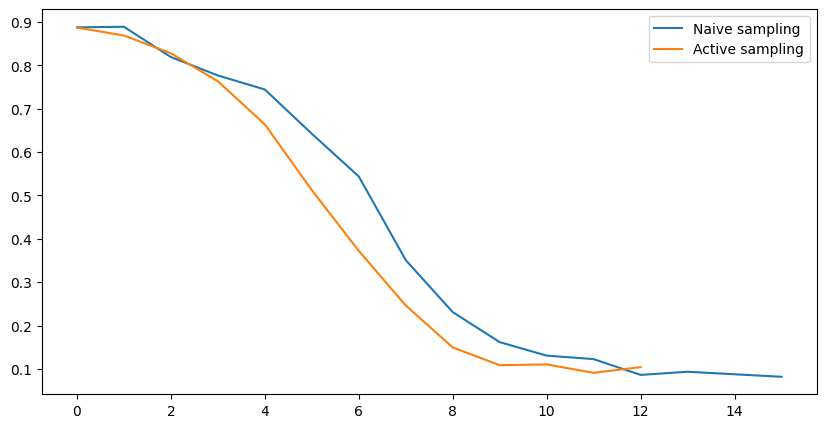

In [4]:
CLASSES = ['flaA', 'hapR', 'luxO_D47E', 'manA', 'potD1', 'rbmB', 'vpsL',
       'vpvC_W240R', 'WT']
X_train, y_train, X_test, y_test, Z ,_ = load_data(filter_class = CLASSES)

BUDGET = 1000
BATCH_SIZE = 10
N = 10
plt.figure(figsize=(10,5))

### naive sampling
l_naive = []
print("Begin DH naive sampling.")

accs_passive_all = []
for i in np.arange(N):
    print("Currently on trial %d"%(i))
    queries, error, hs, P, sel, accs_passive = DH_sampling(X_train, y_train, Z, BUDGET, BATCH_SIZE, class_n=9, sampling_method="naive", criteria="index", min_index=10)
    l_naive.append(error)
    print(accs_passive)
    accs_passive_all.append(accs_passive)

#maximum length of the sub-arrays in l_naive
max_len = max(len(arr) for arr in l_naive)
for arr in l_naive:
    #add padding to the end of each sub-array
    arr.extend([np.nan] * (max_len - len(arr)))

l_naive = np.array(l_naive)
l_naive = np.nanmean(l_naive, axis=0)
plt.plot(l_naive,label = "Naive sampling")
    
## active sampling
l_active = []
print("Begin DH active sampling.")

dh_selected_all = []

accs_active_all = []
for i in np.arange(N):
    print("Currently on trial %d"%(i))
    queries, error, hs, P, sel, accs_dh = DH_sampling(X_train, y_train, Z, BUDGET, BATCH_SIZE, class_n=9, sampling_method="active", criteria="index", min_index=10)
    l_active.append(error)
    print(accs_dh)
    accs_active_all.append(accs_dh)
    dh_selected_all.append(sel)

#maximum length of the sub-arrays in l_active
max_len = max(len(arr) for arr in l_active)
for arr in l_active:
    #add padding to the end of each sub-array
    arr.extend([np.nan] * (max_len - len(arr)))
    
l_active = np.array(l_active)
l_active = np.nanmean(l_active, axis=0)
plt.plot(l_active,label = "Active sampling")
plt.legend()

In [5]:
#for accs_passive_all and accs_active_all, we need to pad the arrays to the same length
max_len = max(len(arr) for arr in accs_passive_all)
for arr in accs_passive_all:
    #add padding to the end of each sub-array
    arr.extend([np.nan] * (max_len - len(arr)))

max_len = max(len(arr) for arr in accs_active_all)
for arr in accs_active_all:
    #add padding to the end of each sub-array
    arr.extend([np.nan] * (max_len - len(arr)))
#convert to numpy arrays
accs_passive_all = np.array(accs_passive_all)
accs_active_all = np.array(accs_active_all)

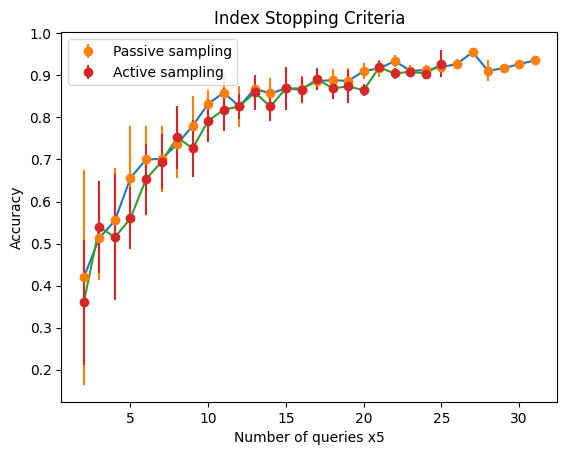

In [10]:
mean_accs_passive = np.nanmean(accs_passive_all, axis = 0)
mean_accs_active = np.nanmean(accs_active_all, axis = 0)
std_accs_passive = np.nanstd(accs_passive_all, axis = 0)
std_accs_active = np.nanstd(accs_active_all, axis = 0)

#select every 10th query
mean_accs_passive = mean_accs_passive[::5]
mean_accs_active = mean_accs_active[::5]
std_accs_passive = std_accs_passive[::5]
std_accs_active = std_accs_active[::5]

plt.figure()
plt.plot(mean_accs_passive)
plt.errorbar(np.arange(len(mean_accs_passive)), mean_accs_passive, yerr = std_accs_passive, fmt = 'o', label = "Passive sampling")
plt.plot(mean_accs_active)
plt.errorbar(np.arange(len(mean_accs_active)), mean_accs_active, yerr = std_accs_active, fmt = 'o', label = "Active sampling")
plt.legend()
plt.xlabel("Number of queries x5")
plt.ylabel("Accuracy")
plt.title("Index Stopping Criteria")
plt.show()

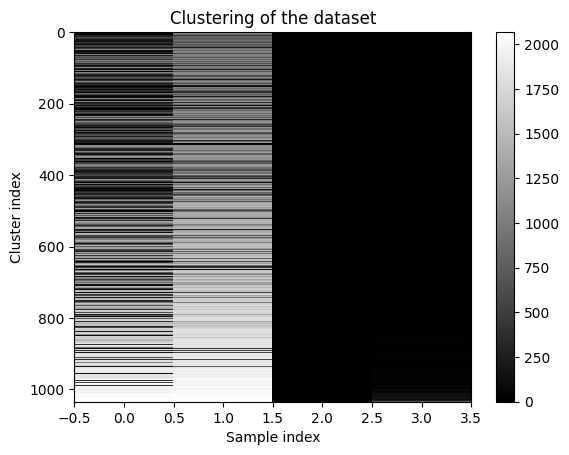

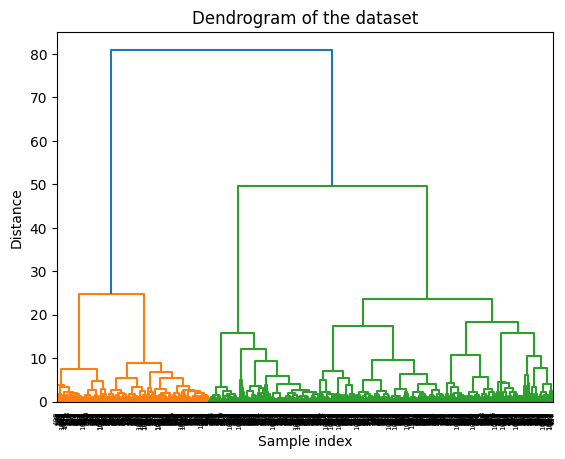

In [7]:
#plot the clustering
plt.figure()
plt.title("Clustering of the dataset")
plt.imshow(Z, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar()
plt.xlabel("Sample index")
plt.ylabel("Cluster index")
plt.show()

#plot the dendrogram
from scipy.cluster.hierarchy import dendrogram
plt.figure()
plt.title("Dendrogram of the dataset")
dendrogram(Z)
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

In [8]:
import pickle
#save accuracies and std deviation
with open('accs_index.pkl', 'wb') as f:
    pickle.dump([mean_accs_passive, mean_accs_active], f)
with open('stds_index.pkl', 'wb') as f:
    pickle.dump([std_accs_passive, std_accs_active], f)

#save selected
with open('dh_index_selected.pkl', 'wb') as f:
    pickle.dump(dh_selected_all, f)

In [9]:
#save test data
with open('dh_index_test_data.pkl', 'wb') as f:
    pickle.dump([X_test, y_test], f)